In [2]:
# importing some vital libaries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def plot_series(time, series, format_='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format_)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase) % period)/ period
    return amplitude * seasonal_pattern(season_time)
                                
                                       
def noise(time, noise_level=1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# lets create some data.
time = np.arange(4 * 365 +1)
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# add some noise into the data.
series += noise(time, noise_level, seed=42)

split_time = 1000
# spliting the data into train and valid.
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

RNN: It is Good for Handling Sequential data. We'll be using the simple RNN.

Lambda Layer: We can do Transformations within the model definition(while defining the model). It doesn't have Internal state. It doesn't consist of weights.

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

from tensorflow.keras.layers import SimpleRNN, Dense, Lambda
from tensorflow.keras.models import Sequential


model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), # expanding the dims
          input_shape=[None]), # i/p can be of any length.
    SimpleRNN(40, return_sequences=True),
    SimpleRNN(40),
    Dense(1),
    Lambda(lambda x:x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
8/8 [==============================] - 5s 645ms/step - loss: 195.6115 - mae: 196.0721
Epoch 2/100
8/8 [==============================] - 1s 68ms/step - loss: 194.9003 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 61ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 191.7773 - mae: 192.4087: 0s - loss: 191.3647 - mae: 191.86
Epoch 5/100
8/8 [==============================] - 0s 61ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 61ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 61ms/step - loss: 185.2864 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 60ms/step - loss: 182.3494 - mae: 183.0459
Epoch 9/100
8/8 [==============================] - 1s 80ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 1s 77ms/step - loss: 175.7152 - mae: 17

8/8 [==============================] - 0s 51ms/step - loss: 11.8159 - mae: 12.4653
Epoch 87/100
8/8 [==============================] - 0s 48ms/step - loss: 23.0008 - mae: 23.5913
Epoch 88/100
8/8 [==============================] - 0s 52ms/step - loss: 18.9315 - mae: 19.2847
Epoch 89/100
8/8 [==============================] - 1s 74ms/step - loss: 51.4313 - mae: 49.9245
Epoch 90/100
8/8 [==============================] - 1s 77ms/step - loss: 52.6332 - mae: 52.4909
Epoch 91/100
8/8 [==============================] - 1s 79ms/step - loss: 68.7091 - mae: 70.8052
Epoch 92/100
8/8 [==============================] - 0s 60ms/step - loss: 55.9178 - mae: 56.8734
Epoch 93/100
8/8 [==============================] - 0s 48ms/step - loss: 44.1616 - mae: 44.5610
Epoch 94/100
8/8 [==============================] - 0s 51ms/step - loss: 37.5483 - mae: 37.6355
Epoch 95/100
8/8 [==============================] - 0s 54ms/step - loss: 43.0041 - mae: 42.8663
Epoch 96/100
8/8 [==============================] - 1

[1e-08, 0.0001, 0, 30]

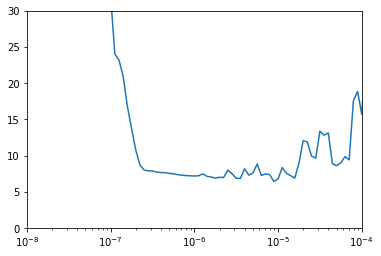

In [6]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1),
          input_shape=[None]),
    SimpleRNN(40, return_sequences=True),
    SimpleRNN(40),
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

# this time I'll change the learning rate.
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
# compile the model.
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# start training.
history=model.fit(dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 4s 454ms/step - loss: 19.9730 - mae: 20.7013
Epoch 2/400
8/8 [==============================] - 0s 45ms/step - loss: 17.8960 - mae: 18.4942
Epoch 3/400
8/8 [==============================] - 0s 46ms/step - loss: 16.7546 - mae: 17.3515
Epoch 4/400
8/8 [==============================] - 0s 61ms/step - loss: 14.2282 - mae: 14.8108
Epoch 5/400
8/8 [==============================] - 1s 73ms/step - loss: 20.0361 - mae: 20.3917
Epoch 6/400
8/8 [==============================] - 1s 77ms/step - loss: 18.5546 - mae: 19.1205
Epoch 7/400
8/8 [==============================] - 1s 79ms/step - loss: 16.8593 - mae: 17.4798
Epoch 8/400
8/8 [==============================] - 1s 70ms/step - loss: 12.6276 - mae: 13.1323
Epoch 9/400
8/8 [==============================] - 1s 64ms/step - loss: 10.8645 - mae: 11.3360
Epoch 10/400
8/8 [==============================] - 1s 64ms/step - loss: 12.3749 - mae: 12.9339
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 53ms/step - loss: 4.7738 - mae: 5.2642
Epoch 88/400
8/8 [==============================] - 0s 60ms/step - loss: 4.9684 - mae: 5.4927
Epoch 89/400
8/8 [==============================] - 0s 51ms/step - loss: 4.6068 - mae: 5.0783
Epoch 90/400
8/8 [==============================] - 0s 52ms/step - loss: 4.9675 - mae: 5.4557
Epoch 91/400
8/8 [==============================] - 0s 52ms/step - loss: 6.9460 - mae: 7.1749
Epoch 92/400
8/8 [==============================] - 1s 71ms/step - loss: 10.7049 - mae: 11.1414
Epoch 93/400
8/8 [==============================] - 1s 79ms/step - loss: 7.5932 - mae: 8.1878
Epoch 94/400
8/8 [==============================] - 1s 82ms/step - loss: 4.8057 - mae: 5.3029
Epoch 95/400
8/8 [==============================] - 1s 70ms/step - loss: 5.3634 - mae: 5.9144
Epoch 96/400
8/8 [==============================] - 0s 59ms/step - loss: 5.8869 - mae: 6.3010
Epoch 97/400
8/8 [==============================] - 0s 56ms/step - loss

8/8 [==============================] - 0s 50ms/step - loss: 4.6943 - mae: 5.1828
Epoch 174/400
8/8 [==============================] - 0s 57ms/step - loss: 4.6258 - mae: 5.0812
Epoch 175/400
8/8 [==============================] - 0s 49ms/step - loss: 4.9786 - mae: 5.4631
Epoch 176/400
8/8 [==============================] - 0s 55ms/step - loss: 4.7365 - mae: 5.2407
Epoch 177/400
8/8 [==============================] - 0s 49ms/step - loss: 4.5760 - mae: 5.0494
Epoch 178/400
8/8 [==============================] - ETA: 0s - loss: 4.5753 - mae: 5.051 - 0s 46ms/step - loss: 4.6065 - mae: 5.0564
Epoch 179/400
8/8 [==============================] - 0s 56ms/step - loss: 5.3762 - mae: 5.9234
Epoch 180/400
8/8 [==============================] - 1s 71ms/step - loss: 5.4340 - mae: 5.9006
Epoch 181/400
8/8 [==============================] - 1s 76ms/step - loss: 5.2459 - mae: 5.7334
Epoch 182/400
8/8 [==============================] - 1s 81ms/step - loss: 5.3237 - mae: 5.8482
Epoch 183/400
8/8 [=======

Epoch 259/400
8/8 [==============================] - 1s 85ms/step - loss: 4.4988 - mae: 4.9644
Epoch 260/400
8/8 [==============================] - 1s 88ms/step - loss: 4.7187 - mae: 5.1862
Epoch 261/400
8/8 [==============================] - 1s 67ms/step - loss: 4.9558 - mae: 5.4337
Epoch 262/400
8/8 [==============================] - 0s 62ms/step - loss: 4.9343 - mae: 5.4233
Epoch 263/400
8/8 [==============================] - 0s 60ms/step - loss: 4.4496 - mae: 4.9193
Epoch 264/400
8/8 [==============================] - 0s 49ms/step - loss: 4.3746 - mae: 4.8377
Epoch 265/400
8/8 [==============================] - 0s 47ms/step - loss: 4.1746 - mae: 4.6552
Epoch 266/400
8/8 [==============================] - 0s 50ms/step - loss: 4.0641 - mae: 4.5267
Epoch 267/400
8/8 [==============================] - 0s 51ms/step - loss: 4.3724 - mae: 4.8229
Epoch 268/400
8/8 [==============================] - 0s 46ms/step - loss: 4.0674 - mae: 4.5398
Epoch 269/400
8/8 [==============================]

8/8 [==============================] - 0s 50ms/step - loss: 4.1632 - mae: 4.6437
Epoch 345/400
8/8 [==============================] - 0s 50ms/step - loss: 4.9149 - mae: 5.4105
Epoch 346/400
8/8 [==============================] - 0s 50ms/step - loss: 4.9923 - mae: 5.4631
Epoch 347/400
8/8 [==============================] - 0s 53ms/step - loss: 4.3201 - mae: 4.8119
Epoch 348/400
8/8 [==============================] - 0s 49ms/step - loss: 4.0919 - mae: 4.5603
Epoch 349/400
8/8 [==============================] - 0s 48ms/step - loss: 4.2541 - mae: 4.7332
Epoch 350/400
8/8 [==============================] - 0s 49ms/step - loss: 4.1225 - mae: 4.5927
Epoch 351/400
8/8 [==============================] - 1s 65ms/step - loss: 4.0616 - mae: 4.5209
Epoch 352/400
8/8 [==============================] - 1s 74ms/step - loss: 4.2319 - mae: 4.7223
Epoch 353/400
8/8 [==============================] - 1s 81ms/step - loss: 4.2674 - mae: 4.7385
Epoch 354/400
8/8 [==============================] - 1s 98ms/ste

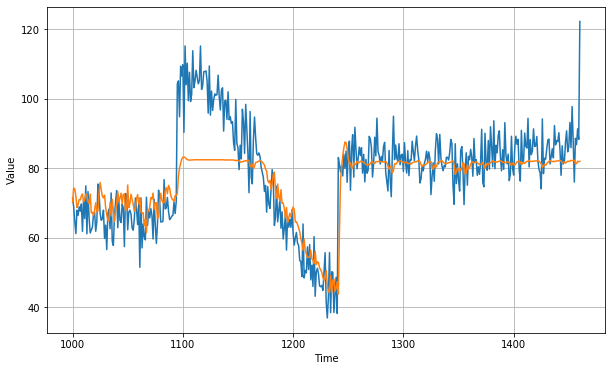

In [8]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
# calulating the mae.
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.911917

<Figure size 432x288 with 0 Axes>

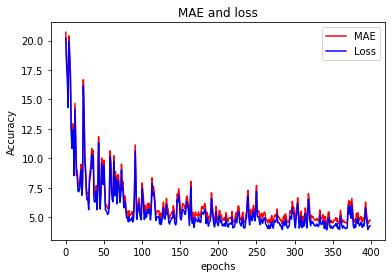

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

# no of epochs.
epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and loss')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()


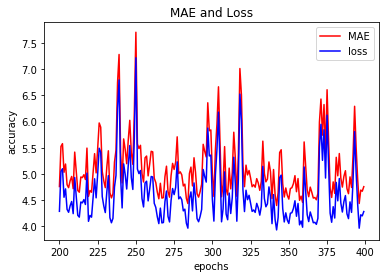

In [11]:
# lets see from 200 till end
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r', label = 'MAE')
plt.plot(epochs_zoom, loss_zoom,'b', label = 'loss')
plt.title('MAE and Loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend()

Lets try with the LSTM.

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

from tensorflow.keras.layers import LSTM, Bidirectional
# create the model.
model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1),
          input_shape=[None]), # input can be of any length.
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    Dense(1),
    Lambda(lambda x: x * 100.)
])

# lets try with LearningRateScheduler.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# I'll begin with small learning rate.
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# lets compile the model.
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# start the training.
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], 
                   verbose=1)

Epoch 1/100
31/31 [==============================] - 14s 464ms/step - loss: 75.5603 - mae: 76.1449
Epoch 2/100
31/31 [==============================] - 2s 71ms/step - loss: 74.4579 - mae: 74.9253
Epoch 3/100
31/31 [==============================] - 2s 71ms/step - loss: 72.9296 - mae: 73.4744
Epoch 4/100
31/31 [==============================] - 3s 82ms/step - loss: 71.3295 - mae: 71.8661
Epoch 5/100
31/31 [==============================] - 3s 86ms/step - loss: 69.5590 - mae: 70.0747
Epoch 6/100
31/31 [==============================] - 2s 72ms/step - loss: 67.4795 - mae: 68.0909
Epoch 7/100
31/31 [==============================] - 2s 79ms/step - loss: 65.3689 - mae: 65.8721
Epoch 8/100
31/31 [==============================] - 3s 104ms/step - loss: 62.8842 - mae: 63.3968 1s - loss: 63.2920 - ma
Epoch 9/100
31/31 [==============================] - 2s 74ms/step - loss: 60.1042 - mae: 60.6280
Epoch 10/100
31/31 [==============================] - 2s 71ms/step - loss: 56.9404 - mae: 57.5199
Ep

31/31 [==============================] - 5s 147ms/step - loss: 5.9709 - mae: 6.4616
Epoch 83/100
31/31 [==============================] - 3s 95ms/step - loss: 6.8553 - mae: 7.3089
Epoch 84/100
31/31 [==============================] - 4s 115ms/step - loss: 6.9069 - mae: 7.4158
Epoch 85/100
31/31 [==============================] - 4s 114ms/step - loss: 6.1131 - mae: 6.6107
Epoch 86/100
31/31 [==============================] - 2s 74ms/step - loss: 5.9855 - mae: 6.4730
Epoch 87/100
31/31 [==============================] - 2s 79ms/step - loss: 6.1264 - mae: 6.5846: 0s - loss: 6.0548 - mae: 6.538
Epoch 88/100
31/31 [==============================] - 3s 102ms/step - loss: 6.2817 - mae: 6.7510
Epoch 89/100
31/31 [==============================] - 3s 94ms/step - loss: 9.0595 - mae: 9.6024
Epoch 90/100
31/31 [==============================] - 3s 111ms/step - loss: 6.7693 - mae: 7.2821 0s - loss: 6.7741 - mae: 7.26
Epoch 91/100
31/31 [==============================] - 3s 103ms/step - loss: 6.8189

[1e-08, 0.0001, 0, 30]

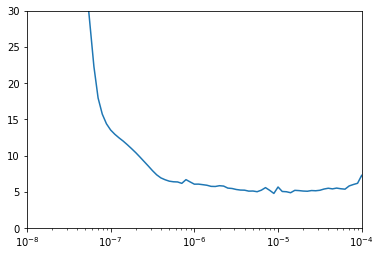

In [13]:
#on the x-axis i'll keep lr and on the other axis i'll keep loss.
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30]) 
# start the x-axis from 10^-8 to 10^-4.
# start the y-axis from 0 to 30.

In [17]:

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1),
          input_shape=[None]),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

# while compiling I'll change the learning rate to 10^-5.
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),
             metrics=['mae'])

history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 16s 509ms/step - loss: 2406.8293 - mae: 34.1113
Epoch 2/500
31/31 [==============================] - 2s 63ms/step - loss: 235.6173 - mae: 12.2840
Epoch 3/500
31/31 [==============================] - 2s 78ms/step - loss: 891.6739 - mae: 23.5347
Epoch 4/500
31/31 [==============================] - 3s 83ms/step - loss: 169.8660 - mae: 10.4812
Epoch 5/500
31/31 [==============================] - 2s 71ms/step - loss: 94.5188 - mae: 7.4130
Epoch 6/500
31/31 [==============================] - 2s 74ms/step - loss: 116.9300 - mae: 8.4911
Epoch 7/500
31/31 [==============================] - 3s 98ms/step - loss: 110.2180 - mae: 8.3685: 1s - loss: 121.4419 
Epoch 8/500
31/31 [==============================] - 2s 74ms/step - loss: 88.8329 - mae: 7.3944
Epoch 9/500
31/31 [==============================] - 2s 70ms/step - loss: 68.2923 - mae: 6.4128
Epoch 10/500
31/31 [==============================] - 3s 90ms/step - loss: 106.5702 - mae: 8.2313
Epo

31/31 [==============================] - 3s 93ms/step - loss: 63.1339 - mae: 6.1457
Epoch 85/500
31/31 [==============================] - 2s 71ms/step - loss: 45.3154 - mae: 5.0871
Epoch 86/500
31/31 [==============================] - 2s 64ms/step - loss: 44.5322 - mae: 5.1198
Epoch 87/500
31/31 [==============================] - 3s 81ms/step - loss: 48.4153 - mae: 5.2745
Epoch 88/500
31/31 [==============================] - 3s 83ms/step - loss: 48.4631 - mae: 5.3210
Epoch 89/500
31/31 [==============================] - 2s 65ms/step - loss: 58.6172 - mae: 5.9140A: 0s - loss: 56.2951 - mae
Epoch 90/500
31/31 [==============================] - 2s 70ms/step - loss: 52.4926 - mae: 5.5664
Epoch 91/500
31/31 [==============================] - 3s 90ms/step - loss: 48.2862 - mae: 5.2960
Epoch 92/500
31/31 [==============================] - 2s 71ms/step - loss: 54.8254 - mae: 5.7115
Epoch 93/500
31/31 [==============================] - 2s 67ms/step - loss: 55.7864 - mae: 5.6732
Epoch 94/500
31/

31/31 [==============================] - 2s 67ms/step - loss: 56.9463 - mae: 5.7741 1s - los - ETA: 0s - loss: 57.0174 - mae: 
Epoch 167/500
31/31 [==============================] - 2s 65ms/step - loss: 44.5773 - mae: 5.0950 1s - loss: 48.7008 - mae
Epoch 168/500
31/31 [==============================] - 3s 85ms/step - loss: 52.1178 - mae: 5.5190 1s -
Epoch 169/500
31/31 [==============================] - 2s 80ms/step - loss: 44.1037 - mae: 5.0728
Epoch 170/500
31/31 [==============================] - 2s 63ms/step - loss: 41.1906 - mae: 4.9036
Epoch 171/500
31/31 [==============================] - 2s 71ms/step - loss: 42.6717 - mae: 4.9083
Epoch 172/500
31/31 [==============================] - 3s 97ms/step - loss: 44.9315 - mae: 5.0781 0s - loss: 45.0100 - mae: 5.
Epoch 173/500
31/31 [==============================] - 2s 68ms/step - loss: 53.5771 - mae: 5.6332
Epoch 174/500
31/31 [==============================] - 2s 67ms/step - loss: 48.7872 - mae: 5.2644
Epoch 175/500
31/31 [=========

31/31 [==============================] - 2s 61ms/step - loss: 47.9953 - mae: 5.3172
Epoch 248/500
31/31 [==============================] - 2s 60ms/step - loss: 44.8302 - mae: 5.1496
Epoch 249/500
31/31 [==============================] - 3s 87ms/step - loss: 38.2420 - mae: 4.6805
Epoch 250/500
31/31 [==============================] - 2s 76ms/step - loss: 41.6514 - mae: 4.9032
Epoch 251/500
31/31 [==============================] - 2s 64ms/step - loss: 46.4624 - mae: 5.2005
Epoch 252/500
31/31 [==============================] - 2s 68ms/step - loss: 43.2429 - mae: 4.9325
Epoch 253/500
31/31 [==============================] - 3s 94ms/step - loss: 40.8021 - mae: 4.8750
Epoch 254/500
31/31 [==============================] - 2s 64ms/step - loss: 42.8705 - mae: 4.9894
Epoch 255/500
31/31 [==============================] - 2s 61ms/step - loss: 50.8376 - mae: 5.3997
Epoch 256/500
31/31 [==============================] - 2s 70ms/step - loss: 42.1889 - mae: 4.8886
Epoch 257/500
31/31 [=============

Epoch 329/500
31/31 [==============================] - 3s 93ms/step - loss: 45.2870 - mae: 5.0946 0s - loss: 44.8771 - mae: 5.
Epoch 330/500
31/31 [==============================] - 2s 68ms/step - loss: 40.6430 - mae: 4.7868
Epoch 331/500
31/31 [==============================] - 2s 61ms/step - loss: 39.5453 - mae: 4.8049
Epoch 332/500
31/31 [==============================] - 2s 73ms/step - loss: 38.5411 - mae: 4.6520
Epoch 333/500
31/31 [==============================] - 3s 87ms/step - loss: 40.2351 - mae: 4.7680
Epoch 334/500
31/31 [==============================] - 2s 61ms/step - loss: 40.0078 - mae: 4.7747
Epoch 335/500
31/31 [==============================] - 2s 63ms/step - loss: 40.3176 - mae: 4.7582
Epoch 336/500
31/31 [==============================] - 3s 82ms/step - loss: 48.9281 - mae: 5.3924
Epoch 337/500
31/31 [==============================] - 3s 82ms/step - loss: 49.3662 - mae: 5.3971
Epoch 338/500
31/31 [==============================] - 2s 64ms/step - loss: 40.1264 - mae

31/31 [==============================] - 2s 70ms/step - loss: 39.7611 - mae: 4.7447
Epoch 408/500
31/31 [==============================] - 2s 67ms/step - loss: 45.1637 - mae: 5.1427
Epoch 409/500
31/31 [==============================] - 3s 85ms/step - loss: 37.0510 - mae: 4.5677
Epoch 410/500
31/31 [==============================] - 2s 71ms/step - loss: 45.7299 - mae: 5.1018
Epoch 411/500
31/31 [==============================] - 2s 62ms/step - loss: 43.1821 - mae: 5.0629
Epoch 412/500
31/31 [==============================] - 2s 78ms/step - loss: 41.3799 - mae: 4.8647
Epoch 413/500
31/31 [==============================] - 3s 86ms/step - loss: 40.0109 - mae: 4.7971
Epoch 414/500
31/31 [==============================] - 2s 74ms/step - loss: 40.0886 - mae: 4.7902
Epoch 415/500
31/31 [==============================] - 3s 85ms/step - loss: 41.2822 - mae: 4.9120
Epoch 416/500
31/31 [==============================] - 3s 90ms/step - loss: 35.8600 - mae: 4.5554 0s - loss: 36.39
Epoch 417/500
31/

31/31 [==============================] - 2s 66ms/step - loss: 36.6981 - mae: 4.6567
Epoch 489/500
31/31 [==============================] - 3s 81ms/step - loss: 38.6747 - mae: 4.6997
Epoch 490/500
31/31 [==============================] - 3s 90ms/step - loss: 34.0779 - mae: 4.4253
Epoch 491/500
31/31 [==============================] - 2s 67ms/step - loss: 39.3640 - mae: 4.7515
Epoch 492/500
31/31 [==============================] - 2s 70ms/step - loss: 41.5503 - mae: 4.8438 1s
Epoch 493/500
31/31 [==============================] - 3s 98ms/step - loss: 34.9113 - mae: 4.4838
Epoch 494/500
31/31 [==============================] - 2s 73ms/step - loss: 36.7861 - mae: 4.5945 1s
Epoch 495/500
31/31 [==============================] - 2s 64ms/step - loss: 37.0944 - mae: 4.6013
Epoch 496/500
31/31 [==============================] - 3s 82ms/step - loss: 37.8383 - mae: 4.6171 2s - loss: 43.9424 - m
Epoch 497/500
31/31 [==============================] - 3s 83ms/step - loss: 39.1942 - mae: 4.7708
Epoch

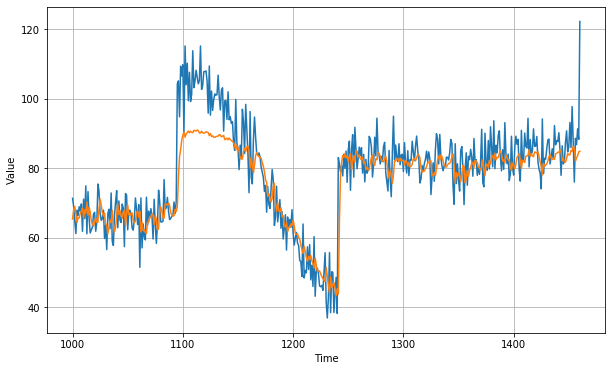

In [18]:
forecast = []
results=[]

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
# comparing the previous mae and current mae. current mae is a bit better.
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.6532536

<Figure size 432x288 with 0 Axes>

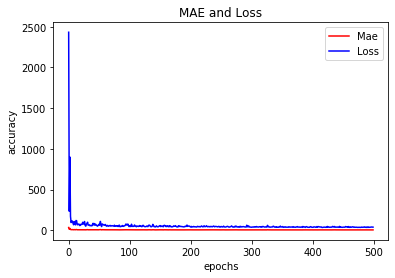

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r', label='Mae')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('MAE and Loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure()


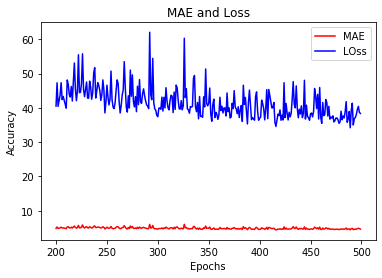

In [21]:
# lets start with 200 epochs.

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', "LOss"])

plt.show()